In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sqlalchemy import Date, cast, func, select
from sqlalchemy.orm import sessionmaker

from shipping_cost_analysis.etl.db_tools import get_engine
from shipping_cost_analysis.etl import preprocessing
from shipping_cost_analysis.models.schema import Customer, Product, Region, Transactions

pd.set_option("display.max_columns", None)

In [2]:
engine = get_engine()
Session = sessionmaker(bind=engine)

with engine.connect() as conn:
    query = (
        select(
            cast(Transactions.transaction_date, Date),
            Transactions.customer_id,
            Transactions.stock_code,
            Transactions.invoice_no,
            Transactions.quantity,
            Transactions.unit_price,
            Transactions.sales,
            Customer.order_postal,
            Customer.order_city,
            Customer.order_state,
            Customer.latitude,
            Customer.longitude,
            Product.landed_cost,
            Product.shipping_cost_1000_r,
            Product.weight,
            Product.category,
            Product.description,
            Region.state,
            Region.region,
        )
        .join(Transactions, Transactions.stock_code == Product.stock_code)
        .join(Customer, Transactions.customer_id == Customer.customer_id)
        .join(Region, Region.order_state == Customer.order_state)
    )

    df = pd.read_sql(query, conn)

In [3]:
display(df.shape)
df.head()

(19555, 19)

,transaction_date,customer_id,stock_code,invoice_no,quantity,unit_price,sales,order_postal,order_city,order_state,latitude,longitude,landed_cost,shipping_cost_1000_r,weight,category,description,state,region
0,2020-12-01,17850,85123A,536365.0,1,15.30,15.30,22473,Heathsville,VA,37.9176,-76.4722,6.0,5.0,2.0,Disposables,Dog and Puppy Pads,Virginia,East
1,2020-12-01,13047,84879,536367.0,6,10.14,60.84,92869,Orange,CA,33.7873,-117.8503,4.0,4.0,1.0,Cleanig Supplies,Pet Odor Eliminator,California,West
2,2020-12-01,17850,85123A,536373.0,1,15.30,15.30,22473,Heathsville,VA,37.9176,-76.4722,6.0,5.0,2.0,Disposables,Dog and Puppy Pads,Virginia,East
3,2020-12-01,15291,22114,536376.0,8,20.70,165.60,48127,Dearborn Heights,MI,42.3370,-83.2733,8.0,5.0,0.5,Grooming,ChomChom Pet Hair Remover - Reusable Cat and D...,Michigan,Central
4,2020-12-01,17850,85123A,536375.0,1,15.30,15.30,22473,Heathsville,VA,37.9176,-76.4722,6.0,5.0,2.0,Disposables,Dog and Puppy Pads,Virginia,East


In [5]:
preprocessing.missing_data(df)

,Total,Percentage Missing
invoice_no,1504,7.69
transaction_date,937,4.79
latitude,415,2.12
longitude,415,2.12


In [6]:
df = df.dropna()

In [7]:
# check different unit price per stock code

df.groupby("stock_code")["unit_price"].unique()

stock_code
20725                                     [9.9, 8.7, 24.78]
21137                                  [20.34, 22.5, 44.76]
22086                                   [17.7, 15.3, 34.74]
22114           [20.7, 23.7, 25.5, 22.5, 27.9, 49.74, 30.6]
22197                                     [4.32, 5.1, 9.78]
22386         [11.7, 9.9, 12.48, 10.44, 10.74, 10.5, 24.78]
22423                      [65.7, 76.5, 30.0, 24.0, 149.76]
22502                                    [35.7, 29.7, 12.0]
22720              [29.7, 25.5, 30.48, 31.08, 20.34, 64.74]
22960                      [22.5, 25.5, 17.76, 27.6, 49.74]
23084                          [12.48, 10.74, 24.78, 10.02]
23203                       [12.48, 11.7, 9.9, 10.74, 10.5]
23284         [47.7, 40.5, 27.48, 49.5, 42.48, 48.0, 99.78]
23298                                   [29.7, 24.9, 30.84]
47566                 [27.9, 22.5, 29.7, 24.9, 25.8, 64.74]
79321     [22.92, 29.7, 25.5, 23.88, 34.5, 27.9, 74.76, ...
82484     [38.7, 33.3, 28.68,

### **Explore distributions & relationships**

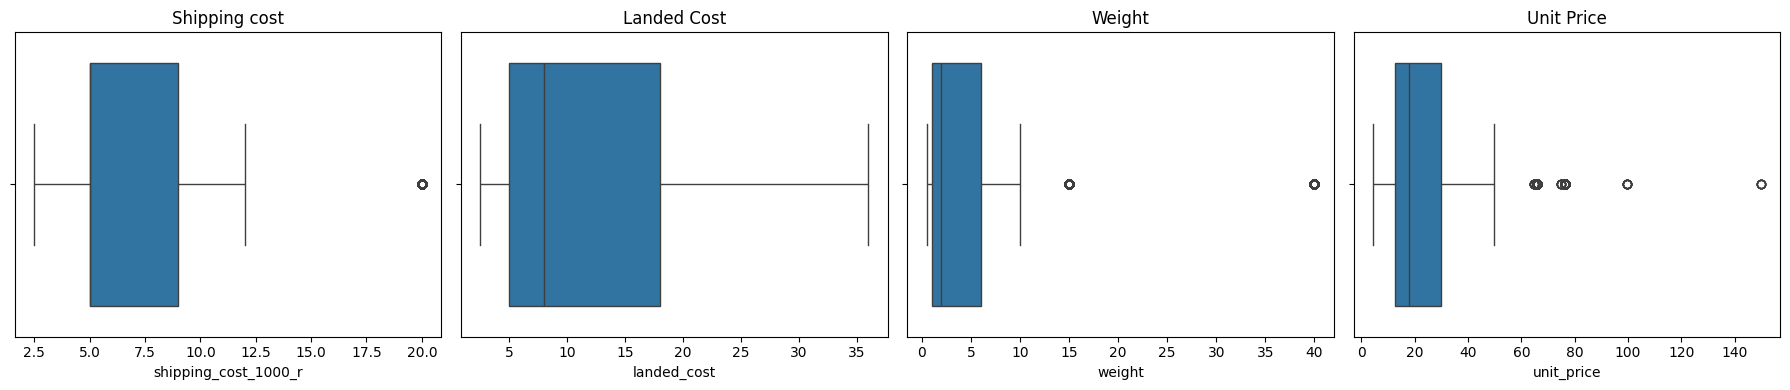

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(18, 4))

sns.boxplot(data=df, x="shipping_cost_1000_r", ax=axs[0])
axs[0].set_title("Shipping cost")

sns.boxplot(data=df, x="landed_cost", ax=axs[1])
axs[1].set_title("Landed Cost")

sns.boxplot(data=df, x="weight", ax=axs[2])
axs[2].set_title("Weight")

sns.boxplot(data=df, x="unit_price", ax=axs[3])
axs[3].set_title("Unit Price")

plt.tight_layout()
plt.show()

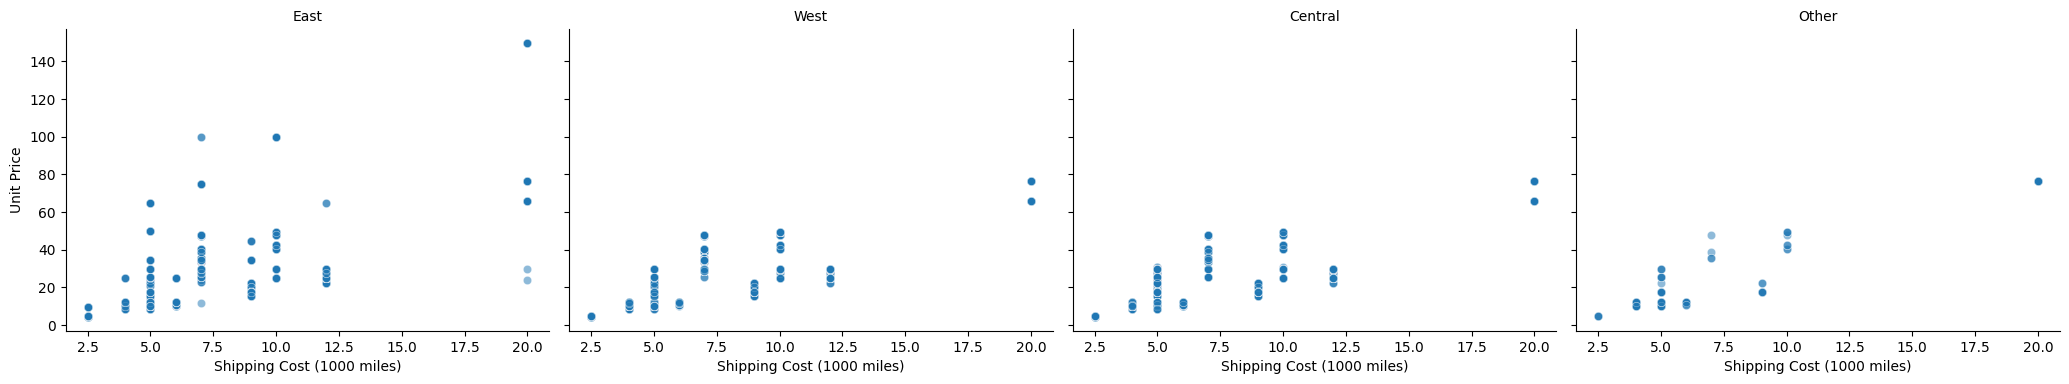

In [9]:
g = sns.FacetGrid(
    df,
    col="region",
    col_wrap=4,
    height=4,
    aspect=1.3,  # (width = 4 × 1.2 = 4.8)
    sharex=True,
    sharey=True,
)

g.map_dataframe(sns.scatterplot, x="shipping_cost_1000_r", y="unit_price", alpha=0.5)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Shipping Cost (1000 miles)", "Unit Price")
plt.subplots_adjust(top=0.9)
plt.show()

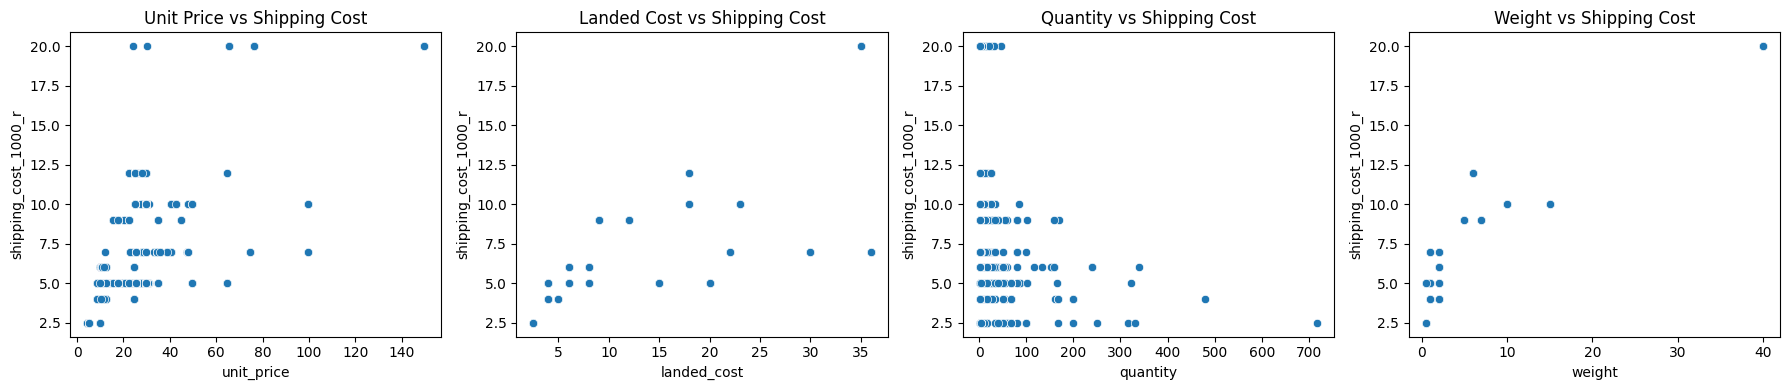

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(18, 4))

sns.scatterplot(data=df, x="unit_price", y="shipping_cost_1000_r", ax=axs[0])
axs[0].set_title("Unit Price vs Shipping Cost")

sns.scatterplot(data=df, x="landed_cost", y="shipping_cost_1000_r", ax=axs[1])
axs[1].set_title("Landed Cost vs Shipping Cost")

sns.scatterplot(data=df, x="quantity", y="shipping_cost_1000_r", ax=axs[2])
axs[2].set_title("Quantity vs Shipping Cost")

sns.scatterplot(data=df, x="weight", y="shipping_cost_1000_r", ax=axs[3])
axs[3].set_title("Weight vs Shipping Cost")

plt.tight_layout()
plt.show()

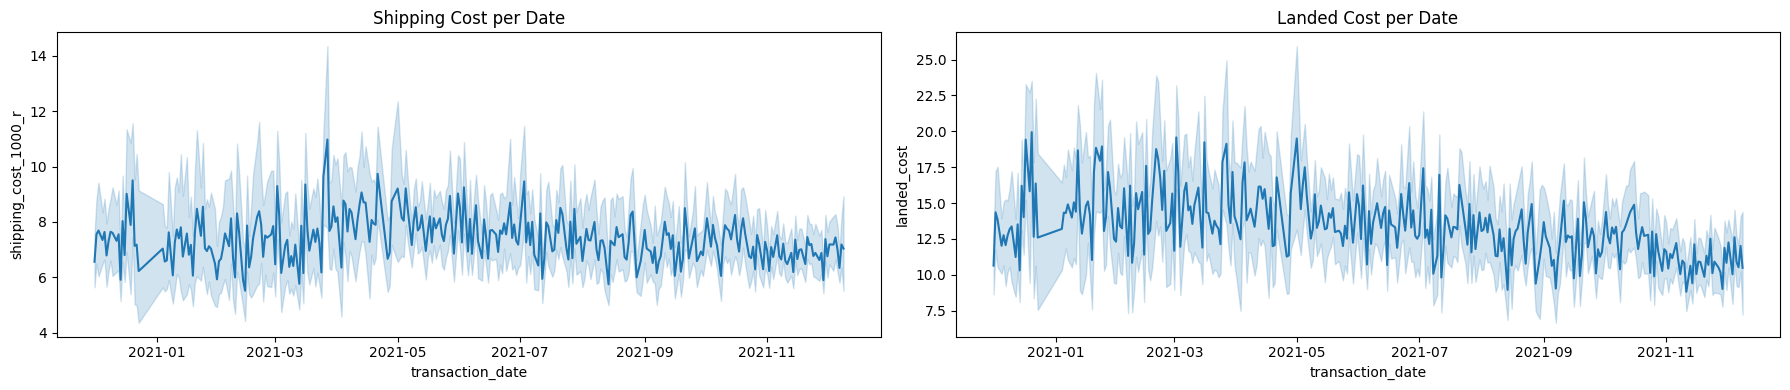

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(18, 4))
sns.lineplot(data=df, x="transaction_date", y="shipping_cost_1000_r", ax=axs[0])
axs[0].set_title("Shipping Cost per Date")
sns.lineplot(data=df, x="transaction_date", y="landed_cost", ax=axs[1])
axs[1].set_title("Landed Cost per Date")
plt.tight_layout()
plt.show()

### **Calculate KPIs**

In [12]:
# customer LTV
cltv = df.groupby("customer_id").agg(cltv=("sales", "sum")).reset_index()
df = df.merge(cltv, on="customer_id")

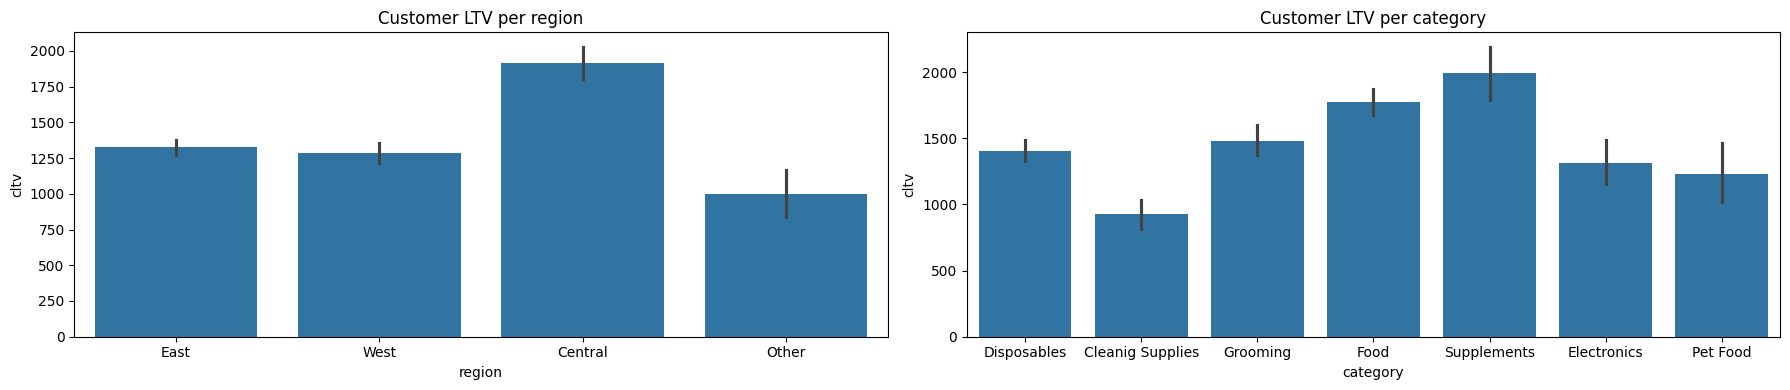

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(18, 4))
sns.barplot(data=df, x="region", y="cltv", ax=axs[0])
sns.barplot(data=df, x="category", y="cltv", ax=axs[1])
axs[0].set_title("Customer LTV per region")
axs[1].set_title("Customer LTV per category")
plt.tight_layout()
plt.show()

In [14]:
# Cost of Goods Sold (COGS)
df["cogs"] = df["landed_cost"] * df["quantity"]

In [15]:
# actual shipping cost per transaction
df["shipping_cost_real"] = df["shipping_cost_1000_r"] * df["quantity"]

In [16]:
# Profit
df["profit_baseline"] = df["sales"] - df["cogs"] - df["shipping_cost_real"]
df["profit_margin"] = df["profit_baseline"] / df["sales"].replace(0, np.nan)

In [17]:
# caculate some ratios
df["shipping_per_sale"] = df["shipping_cost_real"] / df["sales"].replace(0, np.nan)
df["shipping_per_unit"] = df["shipping_cost_real"] / df["quantity"].replace(0, np.nan)
df["shipping_per_unit"] = df["shipping_cost_real"] / df["quantity"].replace(0, np.nan)
df["cogs_per_unit"] = df["cogs"] / df["quantity"].replace(0, np.nan)
df["gross_profit_per_unit"] = (df["unit_price"] - df["landed_cost"] - df["shipping_cost_1000_r"])
df["shipping_vs_cogs"] = df["shipping_cost_real"] / df["cogs"].replace(0, np.nan)


In [18]:
metrics = [ 
 'category',
 'quantity',
 'unit_price',
 'sales',  
 'weight',
 'cltv',
 'cogs',
 'landed_cost', 
 'shipping_cost_1000_r',
 'shipping_cost_real',
 'profit_baseline',
 'profit_margin',
 'shipping_per_sale',
 'shipping_per_unit',
 'cogs_per_unit',
 'gross_profit_per_unit',
 'shipping_vs_cogs']

df[metrics].groupby("category").mean().round(2).T.style.highlight_max(axis=1, color="lightblue").format("{:.2f}").set_properties(
    **{"font-size": "12px", "padding": "3px"}
)

category,Cleanig Supplies,Disposables,Electronics,Food,Grooming,Pet Food,Supplements
quantity,4.77,3.52,1.57,3.57,2.56,5.88,2.58
unit_price,10.08,18.67,30.56,37.38,16.17,12.07,40.74
sales,45.92,56.34,46.36,76.75,35.36,66.12,89.57
weight,1.00,3.74,1.00,15.04,0.76,2.00,8.69
cltv,925.19,1400.06,1313.05,1772.78,1481.75,1232.72,1989.38
cogs,19.07,27.64,35.22,44.22,17.28,35.28,57.83
landed_cost,4.00,8.96,22.60,19.73,7.66,6.00,22.55
shipping_cost_1000_r,4.00,6.99,5.32,10.65,5.00,6.00,8.65
shipping_cost_real,19.07,21.91,8.33,26.29,12.80,35.28,21.08
profit_baseline,7.77,6.79,2.82,6.23,5.28,-4.44,10.65


### **Calculate baseline & hypothesis**

In [19]:
def calc_baseline_shipping(cost_per_unit, quantity):
    if pd.isna(quantity) or quantity <= 0:
        return 0
    # Geometrische Reihe: Sum of 0.7^i for i in range(quantity)
    weights = sum(0.7**i for i in range(int(quantity)))
    return cost_per_unit * weights


df["shipping_cost_baseline"] = df.apply(
    lambda row: calc_baseline_shipping(row["shipping_cost_1000_r"], row["quantity"]),
    axis=1,
)

In [20]:
def hypothesis_factor(q):
    if q <= 1:
        return 1.0
    elif q <= 2:
        return 0.8
    elif q <= 4:
        return 0.6
    elif q <= 7:
        return 0.5
    elif q <= 9:
        return 0.4
    else:
        return 0.3


df["hypothesis_factor"] = df["quantity"].apply(hypothesis_factor)
df["shipping_cost_hypothesis"] = (
    df["shipping_cost_1000_r"] * df["quantity"] * df["hypothesis_factor"]
)

### **Analysis**

In [21]:
df[
    ["shipping_cost_real", "shipping_cost_baseline", "shipping_cost_hypothesis"]
].describe()

,shipping_cost_real,shipping_cost_baseline,shipping_cost_hypothesis
count,16818.000000,16818.000000,16818.000000
mean,20.763943,10.828636,11.992181
std,57.450728,7.759485,17.441647
min,2.500000,2.500000,2.500000
25%,5.000000,5.000000,5.000000
50%,10.000000,8.500000,8.000000
75%,20.000000,12.665000,12.000000
max,2040.000000,66.666662,612.000000


In [22]:
df["shipping_cost_saving"] = df["shipping_cost_real"] - df["shipping_cost_hypothesis"]

# Welche Transaktionen sind "zu teuer"
overpriced = df[df["shipping_cost_saving"] > 0]

# Gesamt-Ersparnis
total_saving = overpriced["shipping_cost_saving"].sum()

In [23]:
df["saving_baseline_vs_real"] = df["shipping_cost_real"] - df["shipping_cost_baseline"]
df["saving_hypothesis_vs_real"] = (
    df["shipping_cost_real"] - df["shipping_cost_hypothesis"]
)

In [24]:
df.groupby("region")[["saving_hypothesis_vs_real"]].sum()

,saving_hypothesis_vs_real
region,
Central,46845.95
East,57924.25
Other,244.30
West,42509.00


### **Plot saving shipping costs**

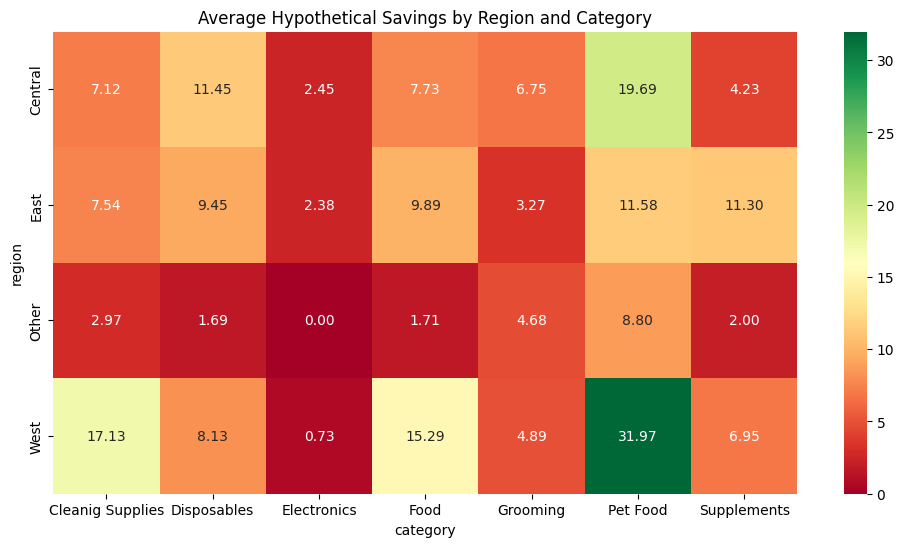

In [25]:
pivot = df.pivot_table(
    values="saving_hypothesis_vs_real",
    index="region",
    columns="category",
    aggfunc="mean"
)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="RdYlGn")
plt.title("Average Hypothetical Savings by Region and Category")
plt.show()



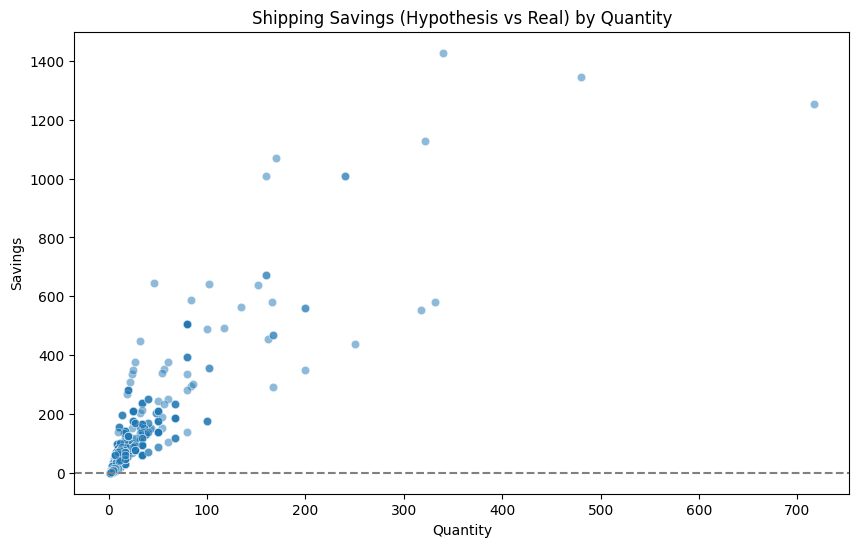

In [26]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="quantity", y="saving_hypothesis_vs_real", alpha=0.5)
plt.title("Shipping Savings (Hypothesis vs Real) by Quantity")
plt.xlabel("Quantity")
plt.ylabel("Savings")
plt.axhline(0, linestyle="--", color="gray")
plt.show()


**Export data for analysis in Tableau**

In [27]:
df.to_excel("../data/ecommerce_shipping_data.xlsx", index=False)